# **Classification | Emotion Recognition in Speech**

## **Load packages**

El dataset adquirido se descargó de Kaggle: [RAVDESS Emotional speech audio](https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio)

In [3]:
from pathlib import Path
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:

def average_audio_duration(directories: list[str]):
    for directory in directories:
        dir_path = Path(directory)
        
        if not dir_path.exists() or not dir_path.is_dir():
            print(f"Directory not found: {directory}")
            continue
        
        durations = []
        
        for file in dir_path.iterdir():
            if file.suffix == ".wav":
                try:
                    y, sr = librosa.load(file, sr=None)  # Cargar el audio sin cambiar la frecuencia de muestreo
                    duration = librosa.get_duration(y=y, sr=sr)  # Obtener la duración en segundos
                    durations.append(duration)
                except Exception as e:
                    print(f"Error processing {file.name}: {e}")

        if durations:
            avg_duration = sum(durations) / len(durations)
            print(f"{directory}: {len(durations)} archivos. Duración promedio: {avg_duration:.2f} segundos")
        else:
            print(f"{directory}: No se encontraron archivos de audio.")

In [5]:
directories = [f'./archive/Actor_{i:02d}' for i in range(1, 25)]

In [6]:
average_audio_duration(directories)

./archive/Actor_01: 60 archivos. Duración promedio: 3.75 segundos
./archive/Actor_02: 60 archivos. Duración promedio: 3.79 segundos
./archive/Actor_03: 60 archivos. Duración promedio: 3.76 segundos
./archive/Actor_04: 60 archivos. Duración promedio: 3.63 segundos
./archive/Actor_05: 60 archivos. Duración promedio: 3.74 segundos
./archive/Actor_06: 60 archivos. Duración promedio: 3.79 segundos
./archive/Actor_07: 60 archivos. Duración promedio: 3.75 segundos
./archive/Actor_08: 60 archivos. Duración promedio: 3.73 segundos
./archive/Actor_09: 60 archivos. Duración promedio: 3.49 segundos
./archive/Actor_10: 60 archivos. Duración promedio: 3.75 segundos
./archive/Actor_11: 60 archivos. Duración promedio: 3.44 segundos
./archive/Actor_12: 60 archivos. Duración promedio: 3.75 segundos
./archive/Actor_13: 60 archivos. Duración promedio: 3.33 segundos
./archive/Actor_14: 60 archivos. Duración promedio: 3.68 segundos
./archive/Actor_15: 60 archivos. Duración promedio: 3.50 segundos
./archive/

Por cada actor se cuenta con 60 audios, estos tienen una duración dentro del rango (3, 4) segundos aproximadamente (en total son 24 actores). Cada audio está etiquetado con `0#-0#-0#-0#-0#-0#-##.wav`

Donde cada 0# representa una caracteristica del audio. A continuación, se presenta el orden de las caracteristicas en la etiqueta de cada audio:

1. **Modality** (01 = full-AV, 02 = video-only, 03 = audio-only).

2. **Vocal channel** (01 = speech, 02 = song).

3. **Emotion** (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

4. **Emotional intensity** (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

5. **Statement** (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

6. **Repetition** (01 = 1st repetition, 02 = 2nd repetition).

7. **Actor** (01 to 24. Odd numbered actors are male, even numbered actors are female)


In [9]:
def make_csv(directories: list[str], output_csv="dataset.csv"):

    data = []
    
    for directory in directories:
        
        for filename in os.listdir(directory): # archives inside of the curret directory
            if filename.endswith(".wav"): # if the file is a video with an _

                emotion_id = filename.split("-")[2] # get the emotion id

                data.append({"filename": filename.split(".")[0], "emotion_id": emotion_id})

    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)
    
    print(f"CSV creado exitosamente: {output_csv}")

In [10]:
make_csv(directories, "ravdess_dataset.csv") # este csv extrae los nombres de los archivos y los ids de las emociones

CSV creado exitosamente: ravdess_dataset.csv


In [11]:
data = pd.read_csv("ravdess_dataset.csv")

In [12]:
data.head()

,filename,emotion_id
0,03-01-01-01-01-01-01,1
1,03-01-01-01-01-02-01,1
2,03-01-01-01-02-01-01,1
3,03-01-01-01-02-02-01,1
4,03-01-02-01-01-01-01,2


In [13]:
unique_emotions = data["emotion_id"].unique()
print(unique_emotions)

[1 2 3 4 5 6 7 8]


Se comprueba que solo existen 8 emociones diferentes en el dataset.

C:\Users\nayel\AppData\Local\Temp\ipykernel_11220\1328610313.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=emotion_names, y=emotion_counts.values, palette="coolwarm")


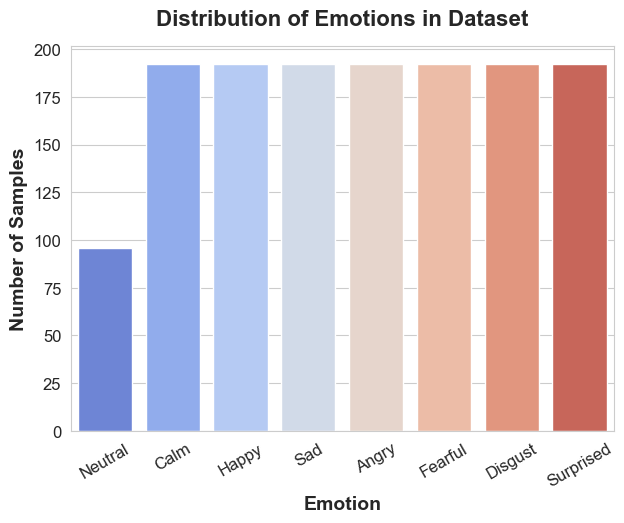

In [10]:
emotion_labels = {
    1: "Neutral", 2: "Calm", 3: "Happy", 4: "Sad",
    5: "Angry", 6: "Fearful", 7: "Disgust", 8: "Surprised"
}

emotion_counts = data["emotion_id"].value_counts().sort_index()

emotion_names = [emotion_labels[eid] for eid in emotion_counts.index]

sns.set_style("whitegrid")
plt.figure(figsize=(7, 5))

ax = sns.barplot(x=emotion_names, y=emotion_counts.values, palette="coolwarm")

plt.xlabel("Emotion", fontsize=14, fontweight="bold")
plt.ylabel("Number of Samples", fontsize=14, fontweight="bold")
plt.title("Distribution of Emotions in Dataset", fontsize=16, fontweight="bold", pad=15)
plt.xticks(rotation=30, fontsize=12)
plt.yticks(fontsize=12)

plt.show()

## **Análisis de espectogramas**

In [16]:
import random
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import math

In [17]:
df_neutral = data[data["emotion_id"] == 1]
df_happy = data[data["emotion_id"] == 3]
df_angry = data[data["emotion_id"] == 5]
df_surprised = data[data["emotion_id"] == 8]

happy_random_ids = random.sample(df_happy["filename"].tolist(), k=4)
angry_random_ids = random.sample(df_angry["filename"].tolist(), k=4)
surprised_random_ids = random.sample(df_surprised["filename"].tolist(), k=4)
neutral_random_ids = random.sample(df_neutral["filename"].tolist(), k=4)

print(happy_random_ids)
print(angry_random_ids)
print(surprised_random_ids)
print(neutral_random_ids)

['03-01-03-01-01-01-07', '03-01-03-01-02-01-15', '03-01-03-02-01-02-04', '03-01-03-01-02-02-06']
['03-01-05-02-02-01-02', '03-01-05-02-02-02-02', '03-01-05-01-02-02-01', '03-01-05-02-02-01-07']
['03-01-08-01-02-02-03', '03-01-08-02-01-01-15', '03-01-08-01-01-01-02', '03-01-08-02-02-02-01']
['03-01-01-01-01-02-11', '03-01-01-01-01-02-03', '03-01-01-01-02-01-02', '03-01-01-01-01-01-24']


In [18]:
def generate_paths(full_path:str, ids:list[str]):
    
    paths = []
    
    for id in ids:
        
        i = id.split("-")[-1][:2]
        #print (i)

        paths.append(f"{full_path}{i}/{id}.wav")
    
    return paths


def plot_multiple_mel_spectrograms(audio_paths: list[str], emotion:str, n_mels=64):
    """
    Plotea múltiples gráficos de MFCC a partir de archivos de audio.
    
    Parámetros:
    - audio_paths: lista de rutas de archivos de audio.
    - n_mels: número de bandas 

    """
    full_path = "./archive/Actor_"
    audio_paths = generate_paths(full_path, audio_paths)
    
    num_audios = len(audio_paths)
    cols = 2  
    rows = math.ceil(num_audios / cols)  
    
    fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
    axes = np.array(axes).reshape(rows, cols)

    fig.suptitle(f"Espectrogramas de Mel para analizar la emoción: {emotion}", fontsize=16, fontweight="bold")
    
    for i, audio_path in enumerate(audio_paths):
        row, col = divmod(i, cols) 
        y, sr = librosa.load(audio_path, sr=None)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        S_db = librosa.power_to_db(S, ref=np.max)

        img = librosa.display.specshow(S_db, x_axis="time", sr=sr, cmap="viridis", ax=axes[row, col])
        axes[row, col].set_title(f"MFCC - {audio_path.split('/')[-1]}")
        fig.colorbar(img, ax=axes[row, col], format="%+2.0f dB")
    
    for i in range(num_audios, rows * cols):
        fig.delaxes(axes.flatten()[i])
    
    plt.tight_layout()
    plt.show()

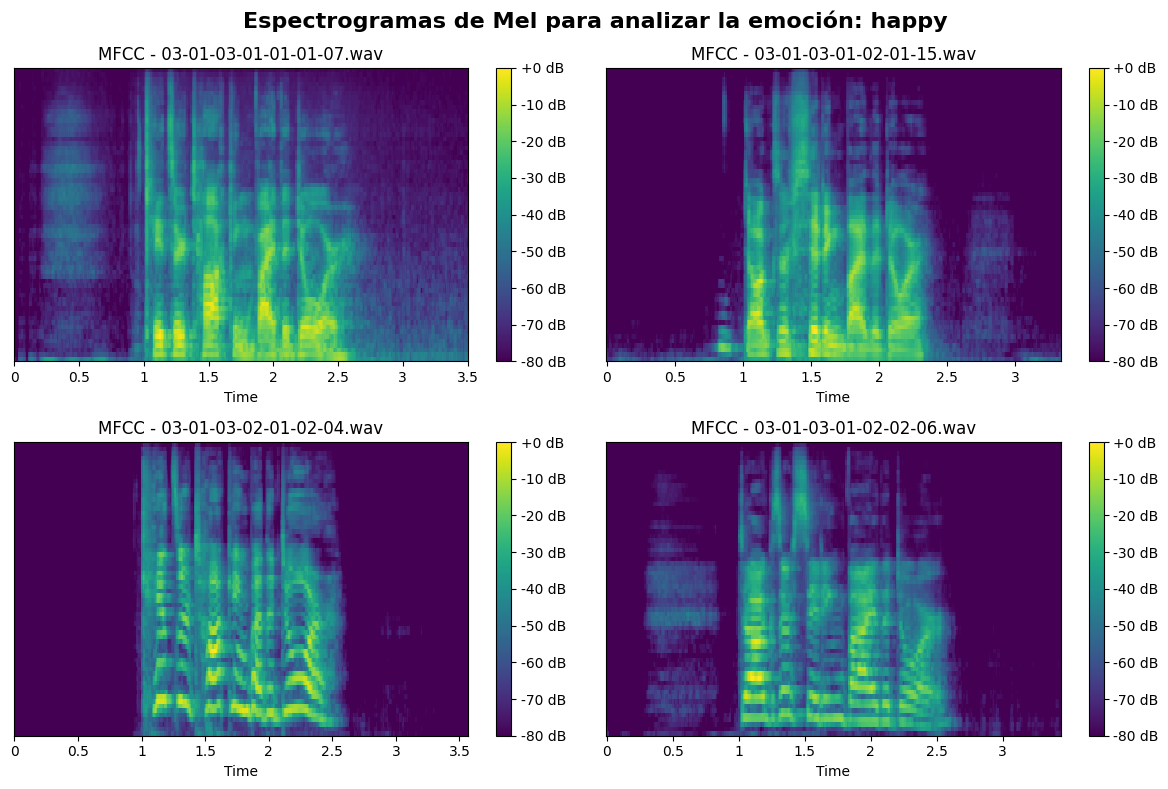

In [19]:
plot_multiple_mel_spectrograms(happy_random_ids, "happy")

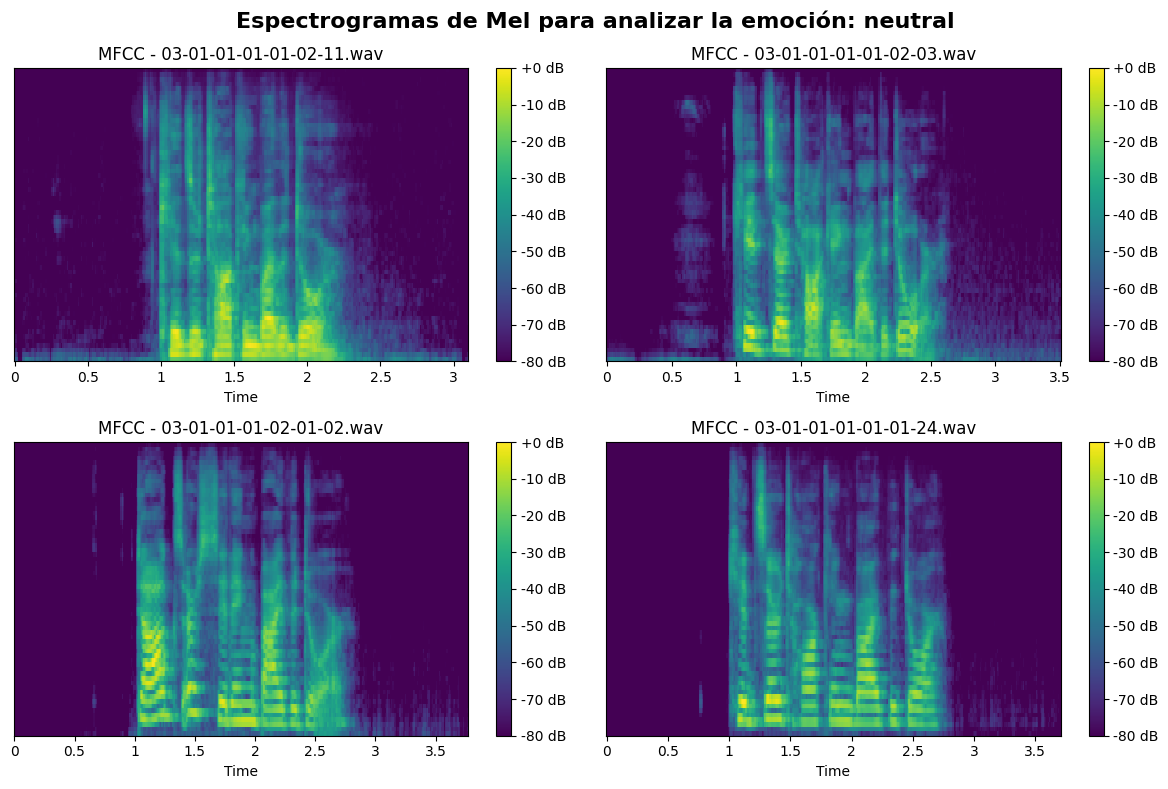

In [20]:
plot_multiple_mel_spectrograms(neutral_random_ids, "neutral")

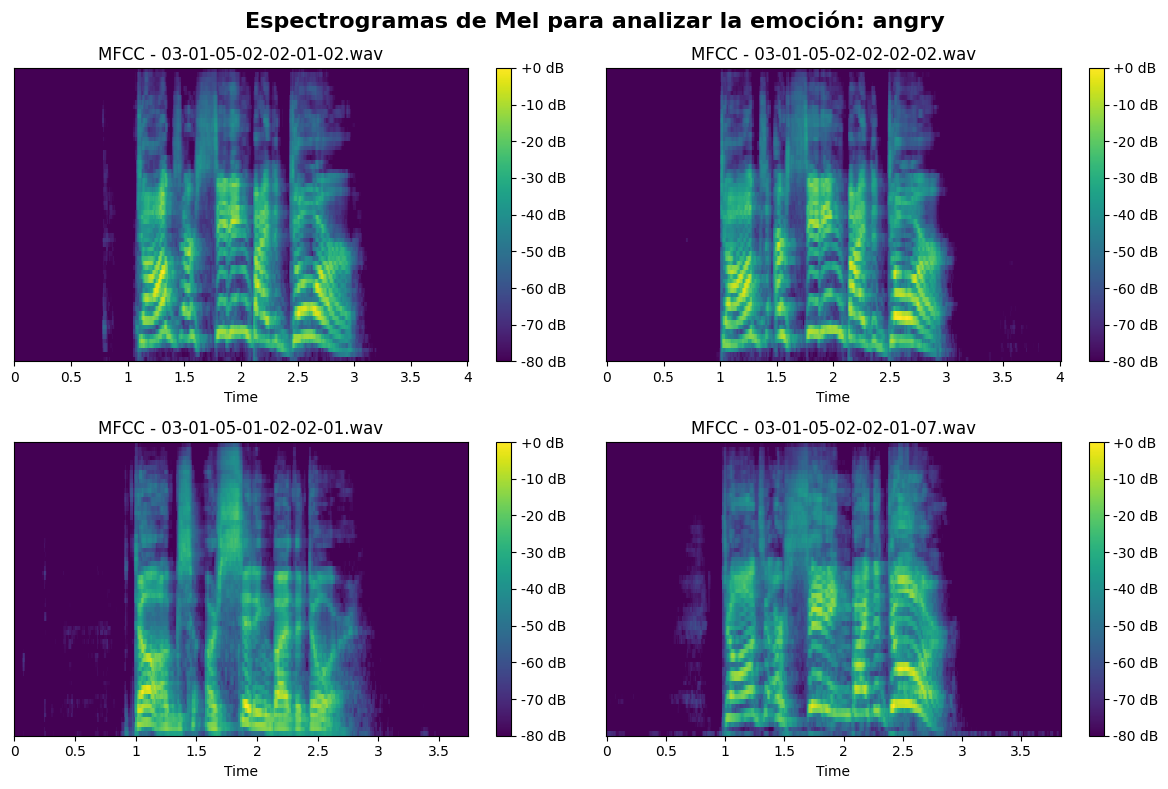

In [21]:
plot_multiple_mel_spectrograms(angry_random_ids, "angry")

Al analizar los espectrogramas de las emociones *Happy*, *Neutral* y *Angry*, se observan diferencias significativas en la distribución de la energía en las frecuencias a lo largo del tiempo. 

El espectrograma de **Happy** muestra una mayor intensidad en las frecuencias medias y altas, con transiciones suaves, reflejando un tono enérgico durante casi todo e tiempo que dura el audio. En contraste, **Neutral** presenta una distribución de energía más uniforme a lo largo del tiempo, con una menor presencia de frecuencias altas, lo que sugiere una entonación estable y sin grandes fluctuaciones. Por otro lado, **Angry** tiene un espectrograma con mayor energía en las frecuencias bajas y medias, con transiciones más bruscas y patrones irregulares, esto es característico de una voz con mayor tensión y agresividad. 

Estas diferencias en la energía y el patrón espectral permiten identificar las emociones en el habla de manera visual.

(4, 128)
[[0.         0.         0.03395972 0.27113497 0.         0.
  0.         0.         0.04824464 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.3032058  0.         0.16922638 0.         0.         0.4532799
  0.08635566 0.03963143 0.         0.11583222 0.19712783 0.10880304
  0.         0.         0.03701551 0.659531   0.5985655  0.
  0.         0.49445257 0.         0.         0.2933478  0.
  0.03268246 0.         0.33472586 0.         0.64761853 0.57158077
  1.1529722  0.2638843  0.         0.         0.         0.
  0.3756973  0.         0.18235618 0.         0.24934138 0.34427693
  0.21561265 0.05840988 0.         0.         0.         0.
  0.         0.31710812 0.         0.2354255  0.         0.15553863
  0.         0.2714683  0.         0.01276253 0.06964161 0.97029203
  0.         0.         0.00258284 0.66095257 0.         0.
  0.3805393  0.03574106 0.         0.2065103  0.         0.
  0.         0.21589962 0.         0.0948339